In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
from fastai.text import *

path = "/content/drive/My Drive/DATA-475/imdb"

In [19]:
# create TextLMDataBunch using the csv in path
#     remember to specify the text column
# data_lm = ...
data_lm = TextLMDataBunch.from_csv(
    path,
    "train.csv",
    text_cols="review"
)

In [20]:
# create TextClasDataBunch using the csv in path
#     remember to specify the text/label column
#     specify test dataset, vocab, and bs
# data_clas = ...
data_clas = TextClasDataBunch.from_csv(
    path,
    "train.csv",
    test = "test.csv",
    text_cols ="review",
    label_cols="sentiment",
    vocab=data_lm.train_ds.vocab,
    bs=32,
)

In [21]:
# create language model learner with AWD_LSTM architecture and drop_mult of 0.5
# lm_learner = ...
lm_learner = language_model_learner(data_lm, arch=AWD_LSTM, drop_mult=.5)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-06
Min loss divided by 10: 6.92E-03


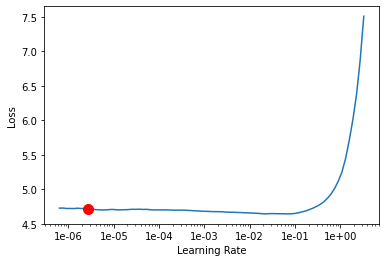

In [22]:
# find a learing rate
lm_learner.lr_find()
lm_learner.recorder.plot(suggestion=True)

In [ ]:
# fit one cycle
lr = lm_learner.recorder.min_grad_lr
lm_learner.fit_one_cycle(2, lr)

epoch,train_loss,valid_loss,accuracy,time
0,4.667805,4.477382,0.263375,04:24
1,4.707440,4.475968,0.263494,04:24


In [23]:
# save the encoder
# save the encoder
lm_learner.save_encoder("model")

In [24]:
lm_learner.predict("this movie talks about Canadian", n_words=20)

'this movie talks about Canadian boxing captains . After former United States Senator Lee Mitch Mikes told'

In [25]:
clas_learner = text_classifier_learner(data_clas, arch=AWD_LSTM, drop_mult=0.5)
clas_learner.load_encoder("model")

RNNLearner(data=TextClasDataBunch;

Train: LabelList (19999 items)
x: TextList
xxbos xxmaj mirage ( 1990 ) is a very rare horror / chiller from 1990 , released here in the xxup uk on the " xxmaj new xxmaj world xxmaj video " label . xxmaj it 's a desert based horror film about a group of young friends who are partying for the weekend , only to be killed off one by one by an unknown force who drives a menacing black truck ! ! ! xxmaj this film has some creepy scenes , and some gore here and there , but i have to say that the acting was so lame , even by low budget standards ! xxmaj but the film was oddly addictive and i liked it , and i never fell asleep or turned it off , which is always a good sign ! i nearly gave this movie 6 / 10 , but seeing as it built up steam along the way , had some good moments of gore and suspense , had some good nudity , and the fact that the blonde in the main female role was a hottie too ! i 'll give it 7 / 10 .,xxbos i enjoyed this film . xxmaj but i was 

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-06
Min loss divided by 10: 1.74E-02


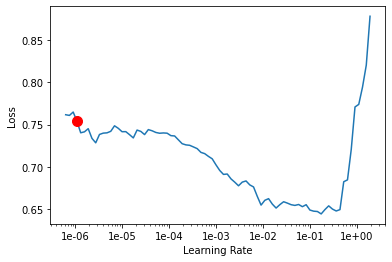

In [26]:
# tune the text_classifier_learner to accpetable accuracy (>80%)
clas_learner.lr_find()
clas_learner.recorder.plot(suggestion=True)

In [27]:
lr = clas_learner.recorder.min_grad_lr
clas_learner.fit_one_cycle(4, lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.731919,0.689277,0.586883,02:41
1,0.714440,0.659940,0.615677,02:48
2,0.700967,0.649986,0.628874,02:46
3,0.702578,0.648902,0.629874,02:46


In [28]:
clas_learner.predict("This is a horrible movie.")

/usr/local/lib/python3.6/dist-packages/fastai/text/data.py:339: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  idx_min = (t != self.pad_idx).nonzero().min()


(Category tensor(1), tensor(1), tensor([0.2663, 0.7337]))

In [29]:
clas_learner.predict("This is a great movie,")

(Category tensor(1), tensor(1), tensor([0.0855, 0.9145]))

In [30]:
# Check the label mapping
# suppose it returns {'negative': 0, 'positive': 1}
data_clas.train_ds.y.c2i

{'negative': 0, 'positive': 1}

In [31]:
import pandas as pd


df = pd.read_csv(path+"/test.csv")
y_true = tensor(df["sentiment"]=="positive")

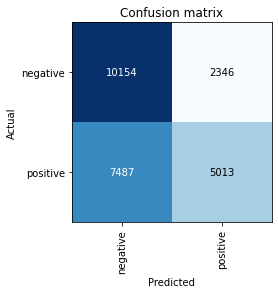

In [32]:
interp = TextClassificationInterpretation.from_learner(
    clas_learner, 
    ds_type=DatasetType.Test  ## test removed 
)
interp.y_true = tensor(df["sentiment"]=="positive")
interp.plot_confusion_matrix()

In [33]:
from fastai.metrics import accuracy

In [34]:
accuracy(interp.preds, interp.y_true)

tensor(0.6067)